# image reconstruction

## Import libraries

In [198]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## Load data

In [199]:
directory_data  = './'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

clean_image_train = data['label_train']
input_image_test  = data['input_test'] 
clean_image_test  = data['label_test']

In [200]:
print(clean_image_train.shape)
print(input_image_test.shape)
print(clean_image_test.shape)

(800, 128, 128)
(400, 128, 128)
(400, 128, 128)


## plot data

In [201]:
def plot_image(title, image):
    
    nRow = 6
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[r, c].imshow(image[k], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

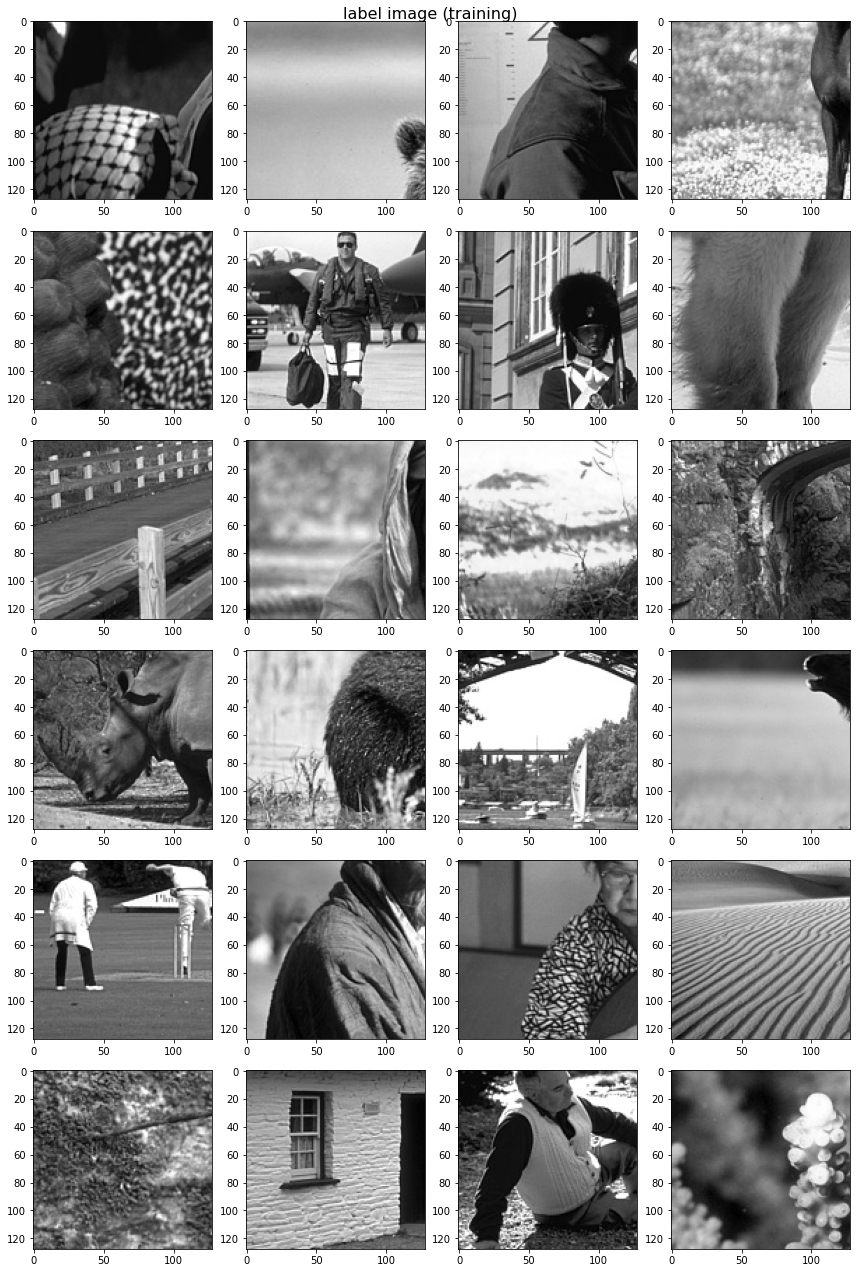

In [202]:
plot_image('label image (training)', clean_image_train)

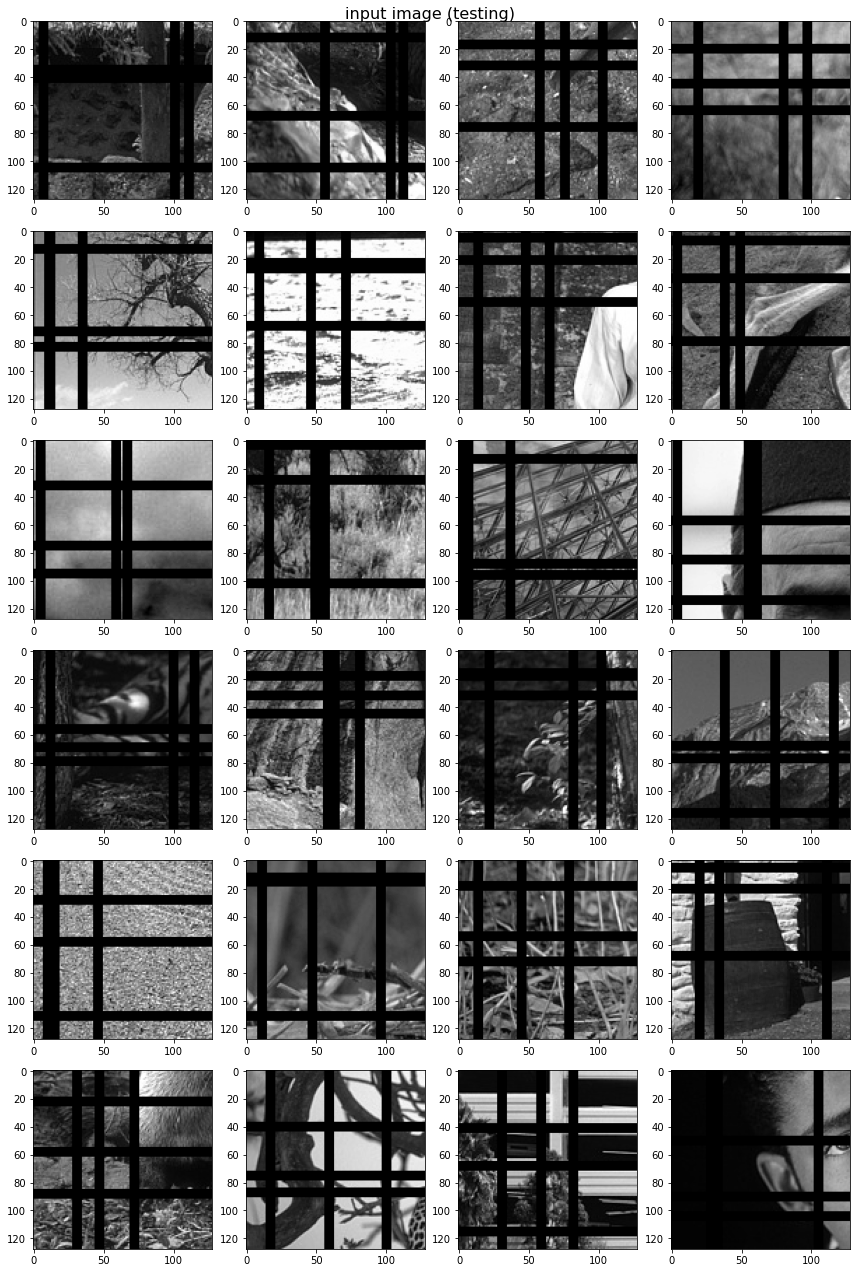

In [203]:
plot_image('input image (testing)', input_image_test)

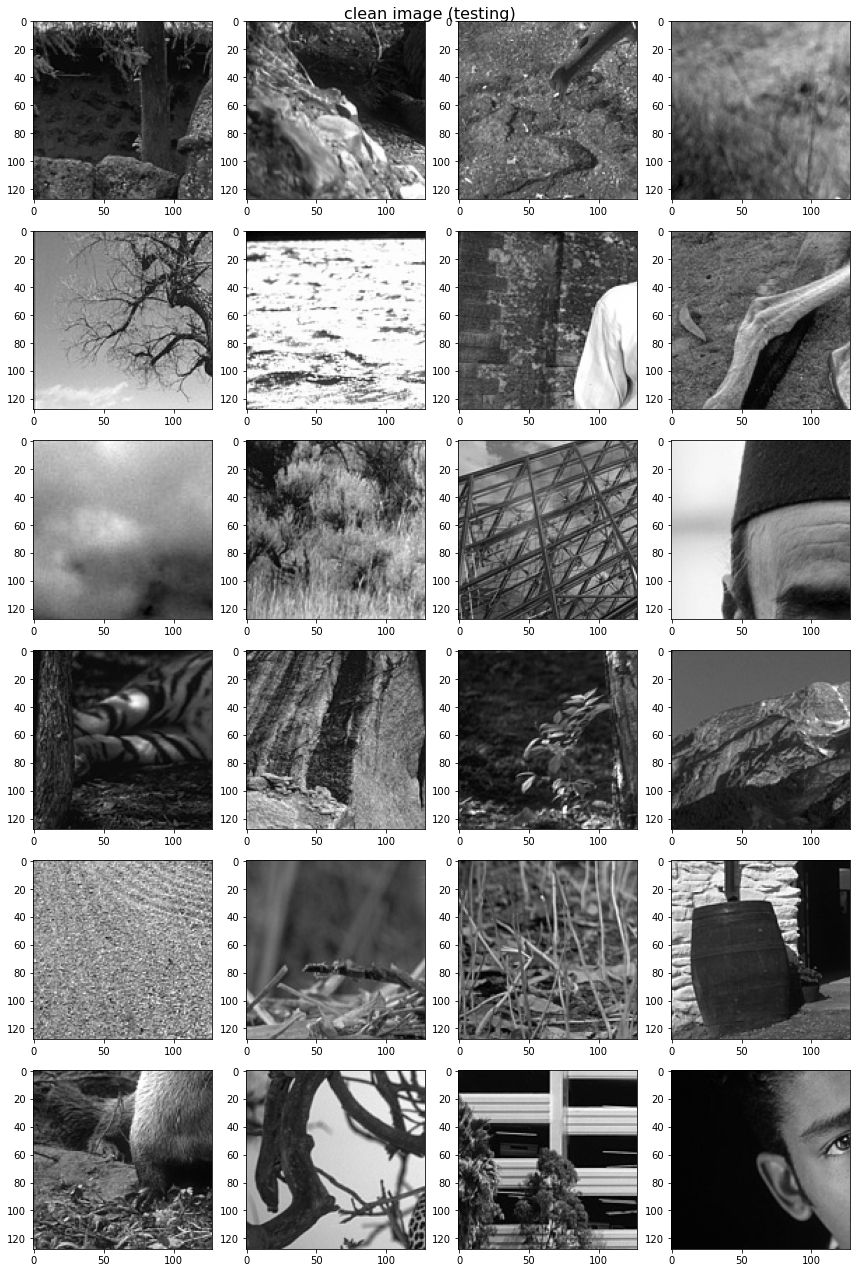

In [204]:
plot_image('clean image (testing)', clean_image_test)

## custom data loader for the training data

In [205]:
class dataset(Dataset):
    
    def __init__(self, clean_image):
        
        self.clean_image = clean_image

    def __getitem__(self, index):
        # ==================================================
        # modify the codes for training data
        #        
        clean_image = self.clean_image[index]
        mask_image = self.clean_image[index]
        clean_image = torch.FloatTensor(clean_image).unsqueeze(dim=0)
        
        
        
        mask_image =torchvision.transforms.ToTensor()(mask_image)
        #print(mask_image.shape,'SHAPE')
        
        
        transform = torchvision.transforms.RandomErasing(p=1, scale=(0.02, 0.43), ratio=(0.05, 0.05), value=0, inplace=False)
        mask_image = transform(mask_image)
        mask_image = transform(mask_image)
        #print((mask_image),"hello")
        mask_image = torch.tensor(mask_image,dtype = torch.float)
        
        
        #drawmask = torchvision.transforms.ToPILImage()(mask_image)
        #drawmask.show()
        

        return (clean_image,mask_image)
        #    
        # ==================================================

    def __len__(self):

        number_image = self.clean_image.shape[0]

        return number_image    

## setting device

In [206]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [207]:
print(device)

cuda


## custom data loader for the testing data

In [208]:
input_image_test = torch.FloatTensor(input_image_test).unsqueeze(dim=1)
clean_image_test = torch.FloatTensor(clean_image_test).unsqueeze(dim=1)

input_image_test = input_image_test.to(device)
clean_image_test = clean_image_test.to(device)

## construct datasets and dataloaders for training and testing

In [209]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 2
#
# ==================================================

dataset_train       = dataset(clean_image_train)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)

## construct a neural network 

In [210]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.e_layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),  
                        nn.MaxPool2d(2,2),
                        nn.ReLU(),
                        nn.BatchNorm2d(2),
        )
        
        self.e_layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.MaxPool2d(2,2),
                        nn.ReLU(),
                        nn.BatchNorm2d(4),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.d_layer1 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(2),
        )
        
        self.d_layer2 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
                        self.e_layer1,
                        self.e_layer2,
                        self.d_layer1, 
                        self.d_layer2,
        )

        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [211]:
model = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#



learning_rate   = 0.005
alpha           = 0.001
number_epoch    = 50
optimizer       = torch.optim.SGD(model.parameters(), lr=learning_rate)

#
# ==================================================

## compute the prediction

In [212]:
def compute_prediction(model, input):

    prediction = model(input)
    
    

    return prediction

Loss


In [213]:
def compute_loss_data_fidelity(prediction, mask):
    # ==================================================
    # fill up the blank
    #

    loss = -torch.mean(mask*torch.log(prediction)+(1-mask)*torch.log(1-prediction))
    #print("lossssss",loss)


    #
    # ==================================================

    return loss

def compute_loss_regularization(prediction):
    # ==================================================
    # fill up the blank
    #
    #print(prediction.shape,"asdfasdfasdfasdf")
    xfront = prediction[:,:,:,1:]
    
    xback =  prediction[:,:,:,:-1]
    
    ybottom = prediction[:,:,1:,:]
    ytop = prediction[:,:,:-1,:]
    
    xres = xfront - xback
    abs_xres = torch.abs(xres)
    mean_abs_xres = torch.mean(abs_xres)
    
    yres = ybottom - ytop
    abs_yres = torch.abs(yres)
    mean_abs_yres = torch.mean(abs_yres)
    
    
    loss = mean_abs_xres + mean_abs_yres 
   
    #
    # ==================================================

    return loss
def compute_loss(prediction, mask, alpha):
    # ==================================================
    # fill up the blank
    #
    
    loss_data_fidelity  = compute_loss_data_fidelity(prediction,mask)
    loss_regularization = compute_loss_regularization(prediction)

    loss = loss_data_fidelity + alpha * loss_regularization

    
    
    #
    # ==================================================

    return loss

def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the PSNR metric

- data1 : mini-batch-size x channel x height x width (torch tensor)
- data2 : mini-batch-size x channel x height x width (torch tensor)

In [214]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [215]:
psnr_test = np.zeros(number_epoch)

## train

In [216]:
def train(model, optimizer, dataloader):

    model.train()

    # ==================================================
    # fill up the blank
    #
    for index_batch, (clean_image,mask_image) in enumerate(dataloader):

        clean_image       = clean_image.to(device)
        mask_image      =   mask_image.to(device)
        #mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction(model,mask_image)
        loss = compute_loss(prediction,clean_image,alpha)
       
        # ==================================================

    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss

    #
    # ==================================================

## test

In [217]:
def test(model, input_image, clean_image):

    model.eval()

    num_steps   = 40
    steps       = np.linspace(0, input_image.shape[0], num_steps+1).astype(int)
    psnr_steps  = np.zeros(num_steps)
    
    for i in range(num_steps):
        input           = input_image[steps[i]:steps[i+1], :, :, :]
        clean           = clean_image[steps[i]:steps[i+1], :, :, :]
        prediction      = compute_prediction(model, input)
        psnr_steps[i]   = compute_psnr(clean, prediction)
    
    psnr = psnr_steps.mean()
    
    return psnr

## train and test

In [218]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    train(model, optimizer, dataloader_train)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    psnr            = test(model, input_image_test, clean_image_test)
    psnr_test[i]    = psnr

100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


---

## functions for presenting the results

---

In [219]:
def function_result_01():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(psnr_test, '-')
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [220]:
def function_result_02():

    

    nRow = 9

    nCol = 4

    size = 3

    

    title = 'testing results'

    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))

    fig.suptitle(title, fontsize=16)


    model.eval()


    num_test = 12


    input_image         = input_image_test[0:num_test]

    clean_image         = clean_image_test[0:num_test]

    prediction_image    = compute_prediction(model, input_image)

    

    input_image         = input_image.detach().cpu().squeeze(axis=1)

    clean_image         = clean_image.detach().cpu().squeeze(axis=1)

    prediction_image    = prediction_image.detach().cpu().squeeze(axis=1)


    nStep   = 3

    t       = 0

    

    for r in range(3):

        for c in range(nCol):

            k = r * nCol * 10 + c * 4 + 10

            

            input       = input_image[t].detach().cpu().squeeze(axis=1)

            clean       = clean_image[t].detach().cpu().squeeze(axis=1)

            prediction  = prediction_image[t].detach().cpu().squeeze(axis=1)

            

            axes[0 + r * nStep, c].imshow(input, cmap='gray')

            axes[1 + r * nStep, c].imshow(clean, cmap='gray', vmin=0, vmax=1)

            axes[2 + r * nStep, c].imshow(prediction, cmap='gray', vmin=0, vmax=1)


            axes[0 + r * nStep, c].xaxis.set_visible(False)

            axes[1 + r * nStep, c].xaxis.set_visible(False)

            axes[2 + r * nStep, c].xaxis.set_visible(False)

            

            axes[0 + r * nStep, c].yaxis.set_visible(False)

            axes[1 + r * nStep, c].yaxis.set_visible(False)

            axes[2 + r * nStep, c].yaxis.set_visible(False)

            

            t = t + 1

    

    plt.tight_layout()

    plt.show()

In [221]:
def function_result_03():
    
    print('final testing psnr = %9.8f' % (psnr_test[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



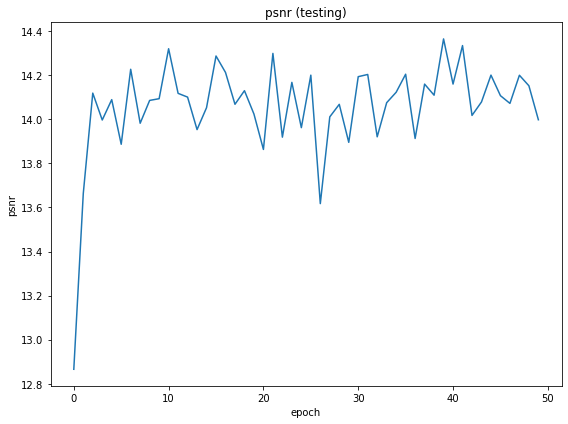


################################################################################
#
# RESULT # 02
#
################################################################################



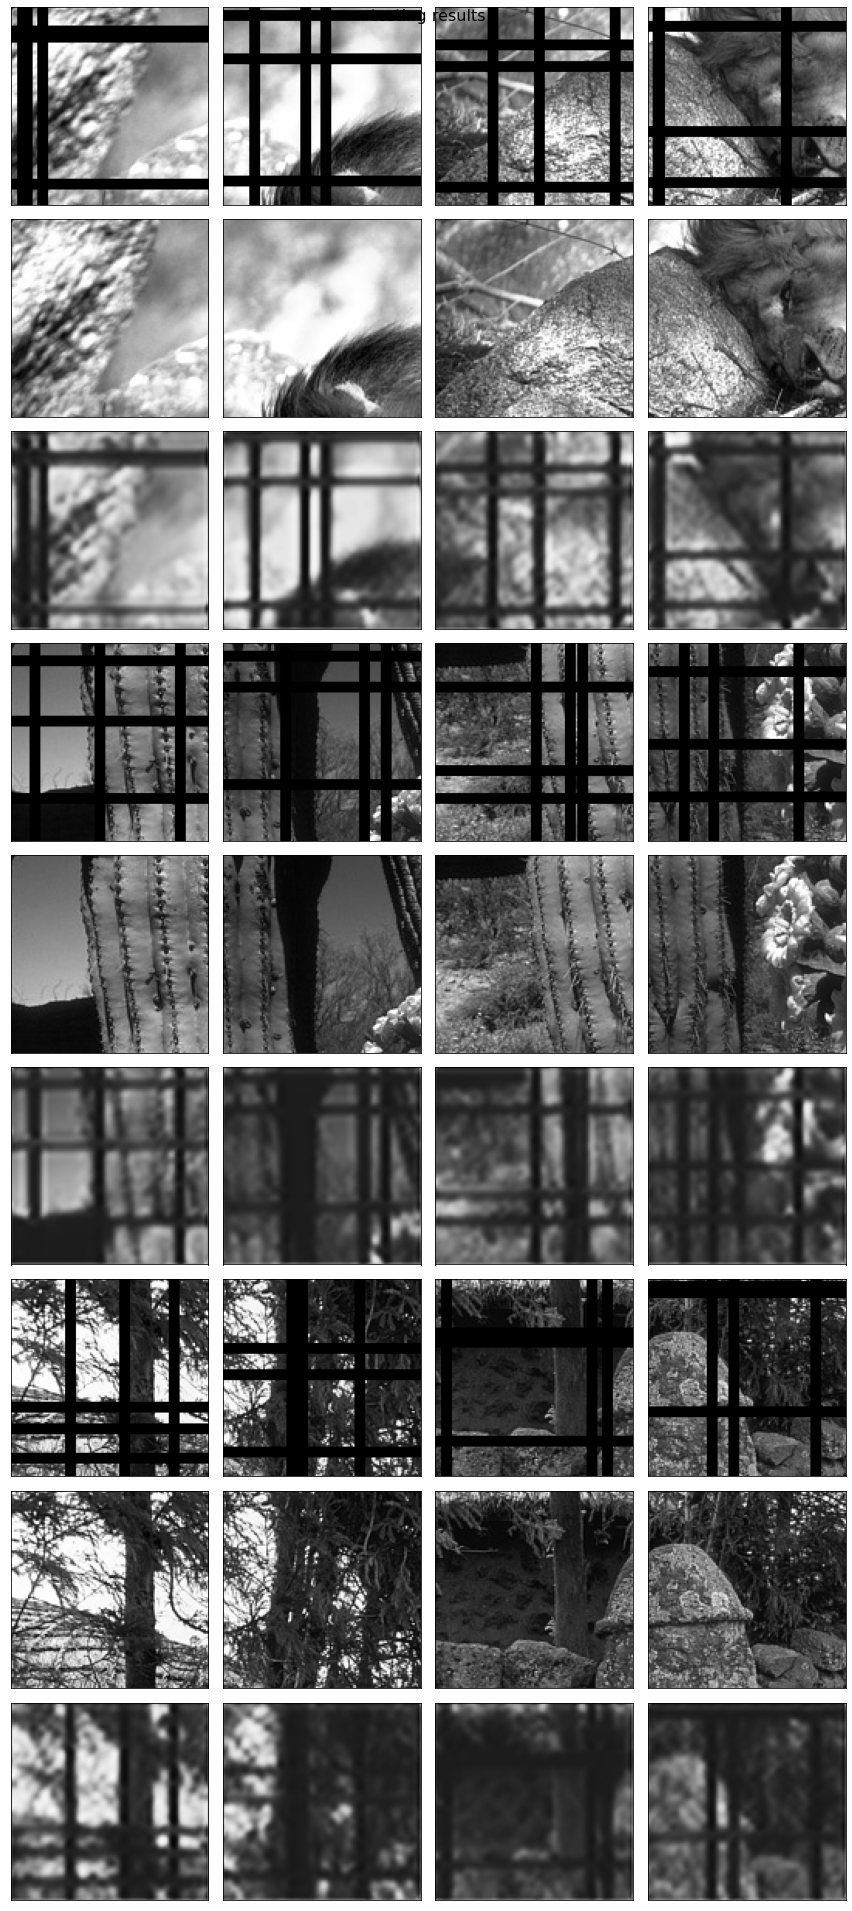


################################################################################
#
# RESULT # 03
#
################################################################################

final testing psnr = 13.99789188


In [222]:
number_result = 3 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1)
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)